# Predicting Power Using the NSRDB<a id='Predicting_Power_Using_the_NSRDB'></a>

In [1]:
import pandas as pd
import numpy as np
import os
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import __version__ as sklearn_version
from scipy.spatial import cKDTree
import h5pyd
import requests
import json
from requests.structures import CaseInsensitiveDict

/Users/edwardseymour/opt/anaconda3/envs/TestEnv/lib/python3.9/site-packages/requests/__init__.py:102: RequestsDependencyWarning: urllib3 (1.26.9) or chardet (5.0.0)/charset_normalizer (2.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({})/charset_normalizer ({}) doesn't match a supported "


In [2]:
nsrdb = h5pyd.File("/nrel/nsrdb/v3/nsrdb_2020.h5", 'r')
x_train = pd.read_csv('../data/X_train2.csv')
y_train = pd.read_csv('../data/Y_train2.csv')
Electricity_cost = pd.read_csv('../data/StatesElectricity.csv')
Attributes = pd.read_csv('../data/Attributes.csv')
url1 = "https://api.geoapify.com/v1/geocode/search?text=1600%20Pennsylvania%20Avenue%20NW%2C%20Washington%2C%20DC%2020500%20United%20States&apiKey=57e88c5179064b9db5ccd0973355973a"
url2 = "https://api.geoapify.com/v1/geocode/search?text=400%20Broad%20Street%2C%20Seattle&2C%20Washington%2098109%20United%20States&apiKey=57e88c5179064b9db5ccd0973355973a"
url3 = "https://api.geoapify.com/v1/geocode/search?text=4803%20Rio%20Grand%20Boulevard%20NW%2C%20Los%20Ranchos%20De%20Albuquerque%2C%20New%20Mexico%2087107%20United%20States&apiKey=57e88c5179064b9db5ccd0973355973a"
url4 = "https://api.geoapify.com/v1/geocode/search?text=350%20First%20Avenue%20NE%2C%20Ceder%20Rapids%2C%20Iowa%2052401%20United%20States&apiKey=57e88c5179064b9db5ccd0973355973a"

In [3]:
y_train.drop(columns = ['Unnamed: 0'],inplace = True)
x_train.drop(columns = ['Unnamed: 0'],inplace = True)

Powered by <a href="https://www.geoapify.com/">Geoapify</a>

In [4]:
headers = CaseInsensitiveDict()
headers['Accept'] = "application/json"
resp1 = requests.get(url1, headers = headers)
resp2 = requests.get(url2, headers = headers)
resp3 = requests.get(url3, headers = headers)
resp4 = requests.get(url4, headers = headers)

print(resp1.status_code)
print(resp2.status_code)
print(resp3.status_code)
print(resp4.status_code)

200
200
200
200


In [5]:
features1 = resp1.json()['features']

properties1 = features1[1]['properties']
lat1 = properties1['lat']
lon1 = properties1['lon']
state1 = properties1['state']

In [6]:
features2 = resp2.json()['features']

properties2 = features2[1]['properties']
lat2 = properties2['lat']
lon2 = properties2['lon']
state2 = properties2['state']

In [7]:
features3 = resp3.json()['features']
features3
properties3 = features3[0]['properties']
lat3 = properties3['lat']
lon3 = properties3['lon']
state3 = properties3['state']

In [8]:
features4 = resp4.json()['features']

properties4 = features4[0]['properties']
lat4 = properties4['lat']
lon4 = properties4['lon']
state4 = properties4['state']

In [9]:
expected_model_version = '1.0'
model_path = '../models/power_predictor.pkl'
if os.path.exists(model_path):
    with open(model_path, 'rb') as f:
        model = pickle.load(f)
    if model.version != expected_model_version:
        print("Expected model version doesn't match version loaded")
    if model.sklearn_version != sklearn_version:
        print("Warning: model created under different sklearn version")
else:
    print("Expected model not found")

In [10]:
Electricity_cost.set_index('State', inplace = True)
Electricity_cost.drop(columns = 'Unnamed: 0', inplace = True)

In [11]:
Electricity_cost.head()

Electricity Prices
State                         
Alabama                   9.84
Alaska                   19.82
Arizona                  10.44
Arkansas                  8.32
California               18.00

In [12]:
Attributes.set_index('Unnamed: 0', inplace = True)

In [13]:
Attributes.head()

air_temperature   alpha      aod    asymmetry  \
Unnamed: 0                                                           
data_source                   MERRA2  MERRA2   MERRA2  climatology   
elevation_correction            True   False     True        False   
physical_max                    70.0     2.5      1.5          1.0   
physical_min                  -100.0     0.0     0.01         -1.0   
psm_scale_factor                10.0   100.0  10000.0        100.0   

                     cld_opd_dcomp cld_reff_dcomp clearsky_dhi clearsky_dni  \
Unnamed: 0                                                                    
data_source                UW-GOES        UW-GOES       output       output   
elevation_correction         False          False        False        False   
physical_max                  80.0           80.0        800.0       1350.0   
physical_min                   0.0            0.0          0.0          0.0   
psm_scale_factor             100.0          100.0          1.0          1.0   

                     clearsky_ghi cloud_press_acha  ...   ozone  \
Unnamed: 0                                          ...           
data_source                output          UW-GOES  ...  MERRA2   
elevation_correction        False            False  ...   False   
physical_max               1350.0           1100.0  ...     0.5   
physical_min                  0.0              0.0  ...     0.2   
psm_scale_factor              1.0              1.0  ...  1000.0   

                     relative_humidity solar_zenith_angle     ssa  \
Unnamed: 0                                                          
data_source                    derived         calculated  MERRA2   
elevation_correction             False              False   False   
physical_max                     100.0              180.0     1.0   
physical_min                       0.0                0.0     0.0   
psm_scale_factor                 100.0              100.0   100.0   

                     surface_albedo surface_pressure time_index  \
Unnamed: 0                                                        
data_source               MODIS-IMS           MERRA2        NaN   
elevation_correction          False             True        NaN   
physical_max                    1.0           1100.0        NaN   
physical_min                    0.0            300.0        NaN   
psm_scale_factor              100.0              1.0        NaN   

                      total_precipitable_water wind_direction wind_speed  
Unnamed: 0                                                                
data_source                             MERRA2         MERRA2     MERRA2  
elevation_correction                      True          False      False  
physical_max                              15.0          360.0       40.0  
physical_min                               0.0            0.0        0.0  
psm_scale_factor                          10.0            1.0       10.0  

[5 rows x 28 columns]

In [14]:
def getLocationData(lat, lon, cols = ['meta']):
    
    tree = cKDTree(nsrdb['coordinates'])
    dist, pos = tree.query(np.array([lat, lon]))
    
    df = pd.DataFrame(columns = cols)
    
    for col in cols:
        df[col] = nsrdb[col][:, pos]
    
    return df

In [15]:
columns = ['air_temperature', 'relative_humidity', 'dew_point', 'wind_speed', 'surface_pressure', 'total_precipitable_water', 'ghi']
Locationdf1 = getLocationData(lat1, lon1, cols = columns)
Locationdf2 = getLocationData(lat2, lon2, cols = columns)
Locationdf3 = getLocationData(lat3, lon3, cols = columns)
Locationdf4 = getLocationData(lat4, lon4, cols = columns)
for col in columns:
    scale = float(Attributes.loc['scale_factor', col])
    Locationdf1[col] = Locationdf1[col] / scale
    Locationdf2[col] = Locationdf2[col] / scale
    Locationdf3[col] = Locationdf3[col] / scale
    Locationdf4[col] = Locationdf4[col] / scale

In [16]:
column_mapper = {'air_temperature': 'TempOut',
                'surface_pressure': 'Bar',
                'relative_humidity': 'OutHum',
                'wind_speed': 'WindSpeed',
                'dew_point': 'DewPt',
                'ghi': 'SolarRad',
                'total_precipitable_water': 'Rain'}
Locationdf1.rename(columns = column_mapper, inplace=True)
Locationdf1['Bar'] = Locationdf1['Bar']
Locationdf1['Rain'] = Locationdf1['Rain'] / 0.25
Locationdf1['SolarEnergy'] = Locationdf1['SolarRad'] * 0.5 / 11.622
Locationdf1['Temp_Pressure_ratio'] = Locationdf1['TempOut'] / Locationdf1['Bar']
Locationdf2.rename(columns = column_mapper, inplace=True)
Locationdf2['Bar'] = Locationdf2['Bar']
Locationdf2['Rain'] = Locationdf2['Rain'] / 0.25
Locationdf2['SolarEnergy'] = Locationdf2['SolarRad'] * 0.5 / 11.622
Locationdf2['Temp_Pressure_ratio'] = Locationdf2['TempOut'] / Locationdf2['Bar']
Locationdf3.rename(columns = column_mapper, inplace=True)
Locationdf3['Bar'] = Locationdf3['Bar']
Locationdf3['Rain'] = Locationdf3['Rain'] / 0.25
Locationdf3['SolarEnergy'] = Locationdf3['SolarRad'] * 0.5 / 11.622
Locationdf3['Temp_Pressure_ratio'] = Locationdf3['TempOut'] / Locationdf3['Bar']
Locationdf4.rename(columns = column_mapper, inplace=True)
Locationdf4['Bar'] = Locationdf4['Bar']
Locationdf4['Rain'] = Locationdf4['Rain'] / 0.25
Locationdf4['SolarEnergy'] = Locationdf4['SolarRad'] * 0.5 / 11.622
Locationdf4['Temp_Pressure_ratio'] = Locationdf4['TempOut'] / Locationdf4['Bar']

In [17]:
Locationdf1.replace(to_replace = {np.Inf: np.NAN}, inplace = True)
Locationdf1.dropna(inplace = True)
Locationdf2.replace(to_replace = {np.Inf: np.NAN}, inplace = True)
Locationdf2.dropna(inplace = True)
Locationdf3.replace(to_replace = {np.Inf: np.NAN}, inplace = True)
Locationdf3.dropna(inplace = True)
Locationdf4.replace(to_replace = {np.Inf: np.NAN}, inplace = True)
Locationdf4.dropna(inplace = True)

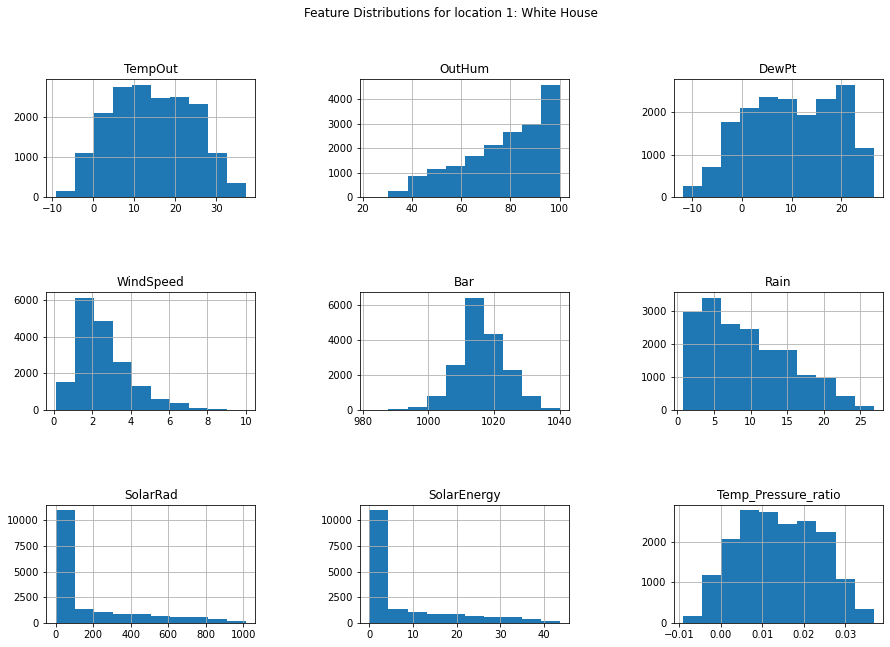

In [18]:
fig, ax = plt.subplots(3, 3, figsize = (15, 10))
Locationdf1.hist(figsize = (15, 10), ax = ax)
plt.subplots_adjust(hspace=0.8, wspace = 0.5)
fig.suptitle("Feature Distributions for location 1: White House");

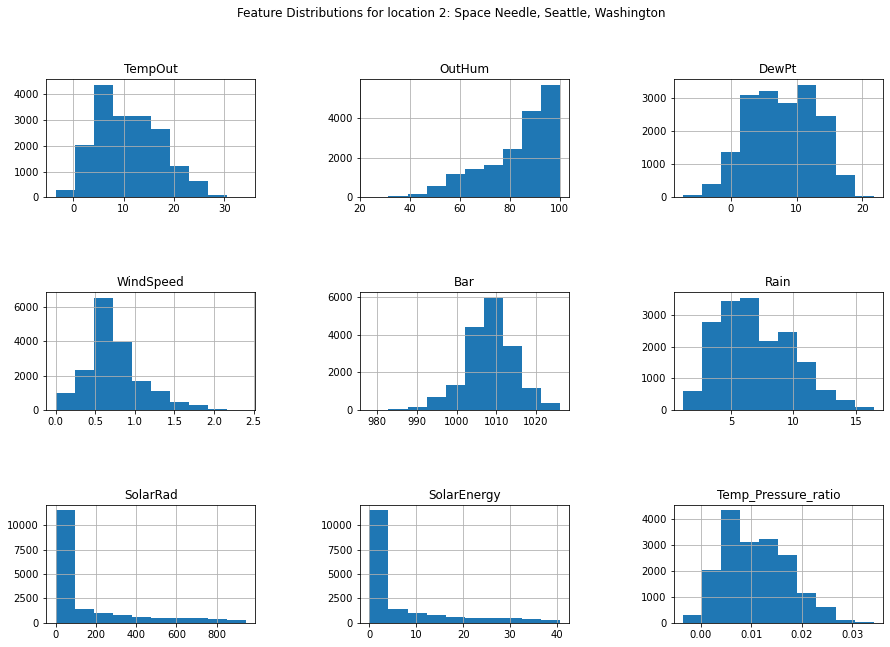

In [19]:
fig, ax = plt.subplots(3, 3, figsize = (15, 10))
Locationdf2.hist(figsize = (15, 10), ax = ax)
plt.subplots_adjust(hspace=0.8, wspace = 0.5)
fig.suptitle("Feature Distributions for location 2: Space Needle, Seattle, Washington");

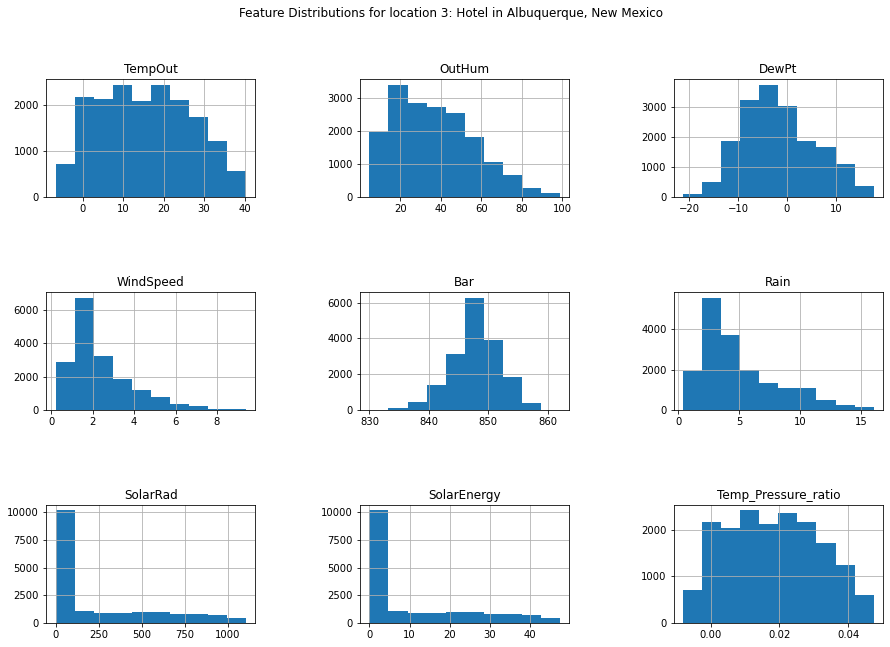

In [20]:
fig, ax = plt.subplots(3, 3, figsize = (15, 10))
Locationdf3.hist(figsize = (15, 10), ax = ax)
plt.subplots_adjust(hspace=0.8, wspace = 0.5)
fig.suptitle("Feature Distributions for location 3: Hotel in Albuquerque, New Mexico");

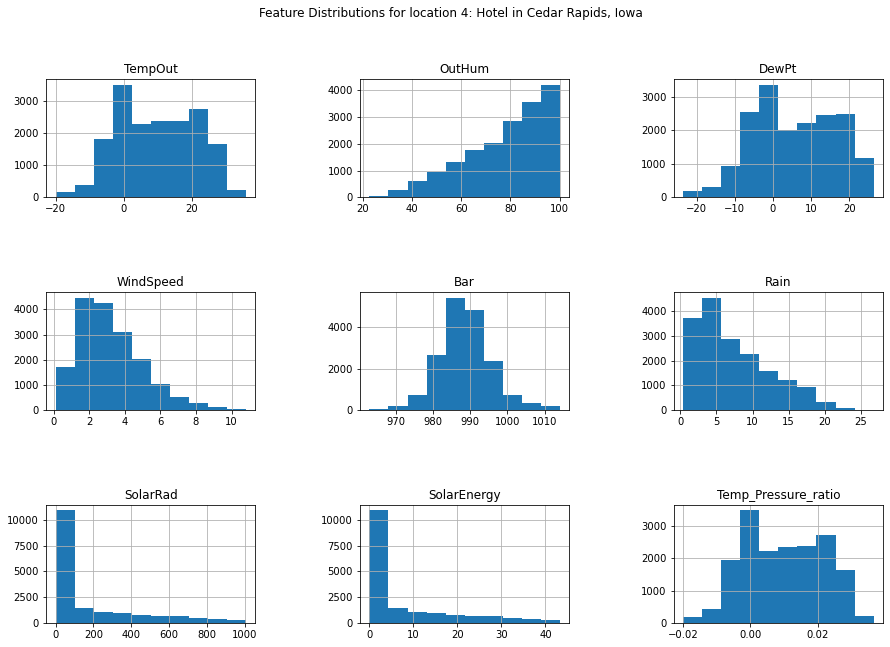

In [21]:
fig, ax = plt.subplots(3, 3, figsize = (15, 10))
Locationdf4.hist(figsize = (15, 10), ax = ax)
plt.subplots_adjust(hspace=0.8, wspace = 0.5)
fig.suptitle("Feature Distributions for location 4: Hotel in Cedar Rapids, Iowa");

In [22]:
model.fit(x_train, y_train)

/Users/edwardseymour/opt/anaconda3/envs/TestEnv/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Pipeline(steps=[('minmaxscaler', MinMaxScaler()), ('pca', PCA(n_components=5)),
                ('gradientboostingregressor',
                 GradientBoostingRegressor(learning_rate=0.04, max_depth=7,
                                           n_estimators=140))])

In [23]:
Locationdf1['Power'] = model.predict(Locationdf1)
Locationdf2['Power'] = model.predict(Locationdf2)
Locationdf3['Power'] = model.predict(Locationdf3)
Locationdf4['Power'] = model.predict(Locationdf4)

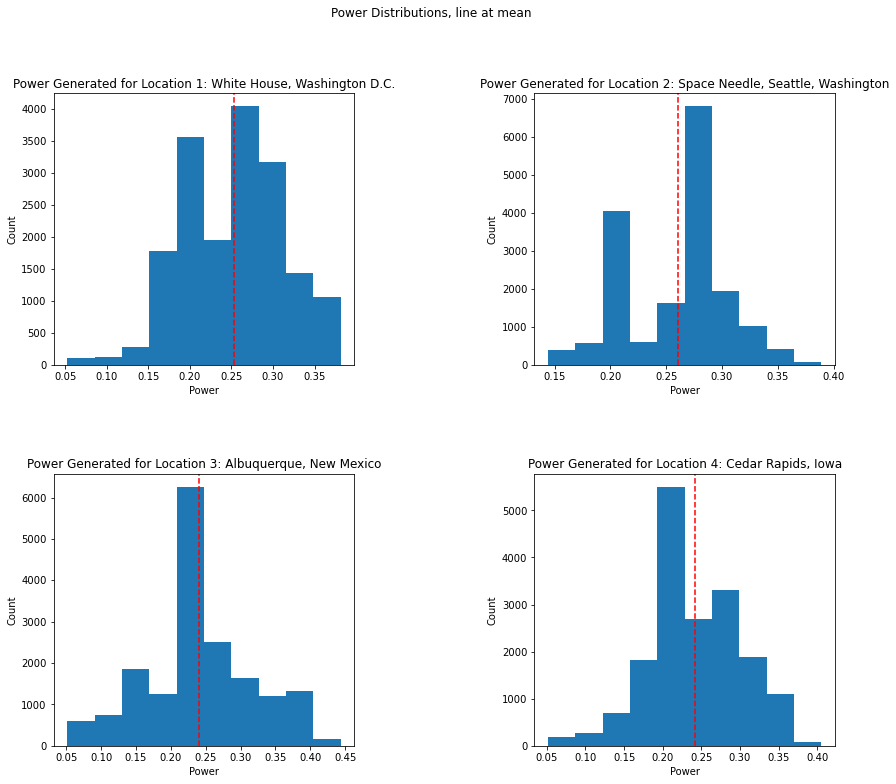

In [24]:
fig, ax = plt.subplots(2, 2, figsize = (14, 12))
plt.subplots_adjust(wspace = 0.6, hspace = 0.4)
ax[0, 0].hist(Locationdf1['Power'], bins = 10)
ax[0, 0].set_title('Power Generated for Location 1: White House, Washington D.C.')
ax[0, 0].set_xlabel('Power')
ax[0, 0].set_ylabel('Count')
ax[0, 0].axvline(x = Locationdf1['Power'].mean(), c = 'r', linestyle = '--')
ax[0, 1].hist(Locationdf2['Power'], bins = 10)
ax[0, 1].set_title('Power Generated for Location 2: Space Needle, Seattle, Washington')
ax[0, 1].set_xlabel('Power')
ax[0, 1].set_ylabel('Count')
ax[0, 1].axvline(x = Locationdf2['Power'].mean(), c = 'r', linestyle = '--')
ax[1, 0].hist(Locationdf3['Power'], bins = 10)
ax[1, 0].set_title('Power Generated for Location 3: Albuquerque, New Mexico')
ax[1, 0].set_xlabel('Power')
ax[1, 0].set_ylabel('Count')
ax[1, 0].axvline(x = Locationdf3['Power'].mean(), c = 'r', linestyle = '--')
ax[1, 1].hist(Locationdf4['Power'], bins = 10)
ax[1, 1].set_title('Power Generated for Location 4: Cedar Rapids, Iowa')
ax[1, 1].set_xlabel('Power')
ax[1, 1].set_ylabel('Count')
ax[1, 1].axvline(x = Locationdf4['Power'].mean(), c = 'r', linestyle = '--')
fig.suptitle('Power Distributions, line at mean');

In [25]:
StateElectricityCost1 = Electricity_cost.loc[state1]['Electricity Prices']
StateElectricityCost2 = Electricity_cost.loc[state2]['Electricity Prices']
StateElectricityCost3 = Electricity_cost.loc[state3]['Electricity Prices']
StateElectricityCost4 = Electricity_cost.loc[state4]['Electricity Prices']

In [26]:
Locationdf1['Money_saved'] = Locationdf1['Power'] * (StateElectricityCost1 / 2)
Locationdf2['Money_saved'] = Locationdf2['Power'] * (StateElectricityCost2 / 2)
Locationdf3['Money_saved'] = Locationdf3['Power'] * (StateElectricityCost3 / 2)
Locationdf4['Money_saved'] = Locationdf4['Power'] * (StateElectricityCost4 / 2)

In [27]:
dollars_saved1 = Locationdf1['Money_saved'].sum() / 100
dollars_saved2 = Locationdf2['Money_saved'].sum() / 100
dollars_saved3 = Locationdf3['Money_saved'].sum() / 100
dollars_saved4 = Locationdf4['Money_saved'].sum() / 100

In [28]:
print('The amount that you would save per year at location 1 (White House) is $' + str(dollars_saved1))
print('The amount that you would save per year at location 2 (Washington) is $' + str(dollars_saved2))
print('The amount that you would save per year at location 3 (Seattle) is $' + str(dollars_saved3))
print('The amount that you would save per year at location 4 (Iowa) is $' + str(dollars_saved4))

The amount that you would save per year at location 1 (White House) is $264.28633865490286
The amount that you would save per year at location 2 (Washington) is $190.80915786689522
The amount that you would save per year at location 3 (Seattle) is $196.9567400852831
The amount that you would save per year at location 4 (Iowa) is $189.9760808124107


A 600 W installation, which this model assumes, would cost around 1800 to 3000 dollars to install. Research suggests that the average time to pay off a solar installation is six to ten years. This largely depends on the electricity cost in your area. In Washington D.C., six to ten years is very achievable, but in the other locations it will take you closer to ten to fifteen years. 